In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
from categorical import one_hot_encode_categorical
from feature_nlp import nlp
from feature_numerical import process_numerical_columns
from location_preprocessing import get_locations_features
from feature_date import cyclical_encode_dates
from parse_amenities import parse_amenities

import json
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [3]:
df = pd.read_csv("Airbnb_Data.csv")
df.set_index('id', inplace=True)

In [4]:
df_amenities_count = parse_amenities(df)

In [5]:
df_categorical = one_hot_encode_categorical(df)

C:\Users\huarq\Desktop\dsw-project\categorical.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical_group].fillna("Unknown", inplace=True)


In [6]:
df_nlp = nlp(df)

In [7]:
df_numerical = process_numerical_columns(df)

mode of bathroom:  1.0


C:\Users\huarq\Desktop\dsw-project\feature_numerical.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['host_response_rate'].fillna(host_response_rate_mean, inplace=True)
C:\Users\huarq\Desktop\dsw-project\feature_numerical.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


C:\Users\huarq\Desktop\dsw-project\location_preprocessing.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['neighbourhood'].fillna("Unknown", inplace=True)
C:\Users\huarq\anaconda3\envs\dsw-venv\lib\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.21632076381055398, -0.22401224191985986, -0.2770374347529286, -0.5504220855040275, -0.6606768557978765, -0.2946450786325852, -0.03504123139792473, -0.052593926347415006, -0.03617799800295145, -0.01601162697726462,

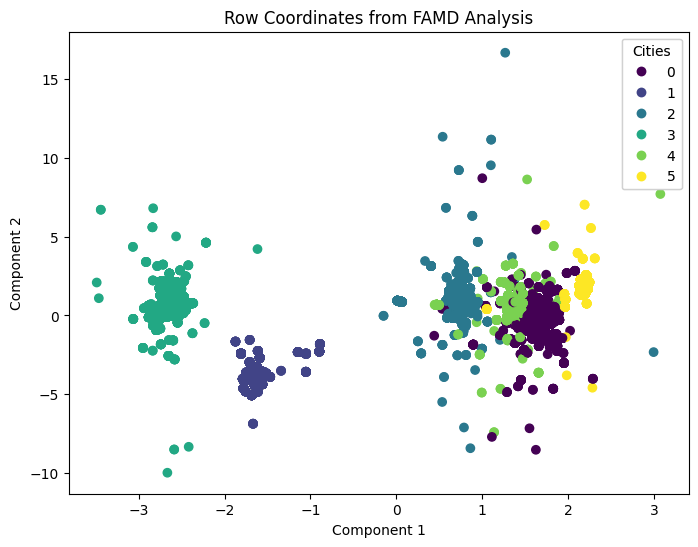

In [8]:
df_locations = get_locations_features(df)

In [9]:
df_datetime = cyclical_encode_dates(df)

Missing rows in first_review: 15864
Missing rows in host_since: 188
Missing rows in last_review: 15827


C:\Users\huarq\Desktop\dsw-project\feature_date.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], errors='coerce')  # Coerce errors will turn problematic parsing into NaT
C:\Users\huarq\Desktop\dsw-project\feature_date.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], errors='coerce')  # Coerce errors will turn problematic parsing into NaT
C:\Users\huarq\Desktop\dsw-project\feature_date.py:29: SettingWithCopyWarning: 
A value is tryin

df_amenities_count = parse_amenities(df)
df_categorical = one_hot_encode_categorical(df)
df_nlp = nlp(df)
df_numerical = process_numerical_columns(df)
df_locations = get_locations_features(df)
df_datetime = cyclical_encode_dates(df)

In [10]:
all_data_df = pd.concat([
    df['log_price'],
    df_amenities_count,
    df_categorical[[
        'one_hot_encoder__room_type_Entire home/apt',
                    'one_hot_encoder__room_type_Private room',
                    'one_hot_encoder__room_type_Shared room', 
                    'one_hot_encoder__cleaning_fee_True',
                 'one_hot_encoder__instant_bookable_t']],
    df_nlp[['description_polarity', 'description_subjectivity']],
    df_numerical[['accommodates', 'beds_per_bedroom',
                  'bed_and_bathrooms']],
    df_locations[['location_component_0', 'location_component_1', 'city']],
    df_datetime
                         
                         ], axis=1)

In [11]:
print(all_data_df.shape)
print(all_data_df.dtypes)

(74111, 18)
log_price                                     float64
amenities_count                               float64
one_hot_encoder__room_type_Entire home/apt       bool
one_hot_encoder__room_type_Private room          bool
one_hot_encoder__room_type_Shared room           bool
one_hot_encoder__cleaning_fee_True               bool
one_hot_encoder__instant_bookable_t              bool
description_polarity                          float64
description_subjectivity                      float64
accommodates                                    int64
beds_per_bedroom                              float64
bed_and_bathrooms                             float64
location_component_0                          float64
location_component_1                          float64
city                                           object
first_review_days_since                       float64
host_since_days_since                         float64
last_review_days_since                        float64
dtype: object


In [12]:
all_data_df.columns[all_data_df.isna().any()].tolist()

[]

In [13]:
X = all_data_df.drop(['log_price', 'city'], axis=1).copy()
X = X.apply(pd.to_numeric)
# Convert boolean columns to integers if there are any
for col in X.columns:
    if X[col].dtype == bool:
        X[col] = X[col].astype(int)

y = all_data_df['log_price'].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [31]:
X_train_tensor = torch.tensor(X_train.astype(np.float32).values)
y_train_tensor = torch.tensor(y_train.astype(np.float32).values)
X_test_tensor = torch.tensor(X_test.astype(np.float32).values)
y_test_tensor = torch.tensor(y_test.astype(np.float32).values)

In [34]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

In [35]:
# Neural network architecture here
class RegressionNN(nn.Module):
    def __init__(self, num_features):
        super(RegressionNN, self).__init__()
        self.layer1 = nn.Linear(num_features, 128) # Input layer
        self.layer2 = nn.Linear(128, 64)           # Hidden layer
        self.layer3 = nn.Linear(64, 1)             # Output layer
        self.relu = nn.ReLU()                      # Activation function
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [36]:
num_features = X_train.shape[1]
model = RegressionNN(num_features)

In [37]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [38]:
# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.4254
Epoch [2/100], Loss: 0.0993
Epoch [3/100], Loss: 0.2870
Epoch [4/100], Loss: 0.3380
Epoch [5/100], Loss: 0.1000
Epoch [6/100], Loss: 0.0973
Epoch [7/100], Loss: 0.1374
Epoch [8/100], Loss: 0.2013
Epoch [9/100], Loss: 0.1822
Epoch [10/100], Loss: 0.1174
Epoch [11/100], Loss: 0.1567
Epoch [12/100], Loss: 0.1965
Epoch [13/100], Loss: 0.1006
Epoch [14/100], Loss: 0.1914
Epoch [15/100], Loss: 0.0985
Epoch [16/100], Loss: 0.2264
Epoch [17/100], Loss: 0.1117
Epoch [18/100], Loss: 0.1503
Epoch [19/100], Loss: 0.2094
Epoch [20/100], Loss: 0.0821
Epoch [21/100], Loss: 0.2742
Epoch [22/100], Loss: 0.2847
Epoch [23/100], Loss: 0.3940
Epoch [24/100], Loss: 0.1691
Epoch [25/100], Loss: 0.2772
Epoch [26/100], Loss: 0.1580
Epoch [27/100], Loss: 0.2711
Epoch [28/100], Loss: 0.1838
Epoch [29/100], Loss: 0.1794
Epoch [30/100], Loss: 0.2317
Epoch [31/100], Loss: 0.2600
Epoch [32/100], Loss: 0.2440
Epoch [33/100], Loss: 0.1652
Epoch [34/100], Loss: 0.1734
Epoch [35/100], Loss: 0

In [39]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).squeeze()
    mse = criterion(predictions, y_test_tensor)
    print(f'Test MSE: {mse.item()}')

Test MSE: 0.2080783247947693


In [41]:
SS_res = torch.sum((y_test_tensor - predictions) ** 2)
SS_tot = torch.sum((y_test_tensor - torch.mean(y_test_tensor)) ** 2)

r_squared = 1 - (SS_res / SS_tot)
print(f'R-squared: {r_squared.item()}')

R-squared: 0.5949623584747314


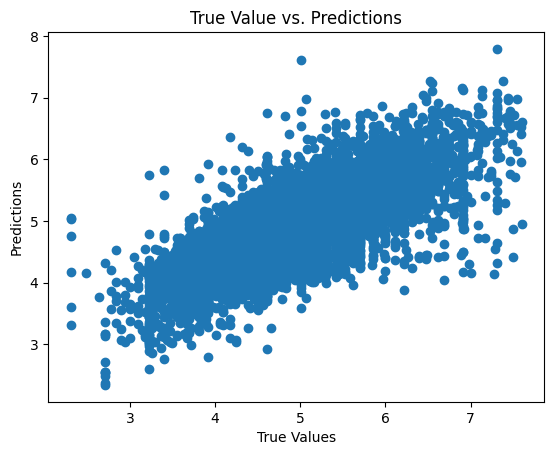

In [44]:
plt.scatter(y_test_tensor, predictions.numpy())
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Value vs. Predictions')
#plt.savefig('plot.png')
plt.show()